Problem statement: To build a CNN based model which can accurately detect melanoma. Melanoma is a type of cancer that can be deadly if not detected early. It accounts for 75% of skin cancer deaths. A solution which can evaluate images and alert the dermatologists about the presence of melanoma has the potential to reduce a lot of manual effort needed in diagnosis.

### Importing Skin Cancer Data
#### To do: Take necessary actions to read the data

### Importing all the important libraries

In [1]:
import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import PIL
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Flatten, Dense
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import Callback, ModelCheckpoint
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input
import warnings 
warnings.filterwarnings('ignore')
# importing various libraries

In [3]:
## If you are using the data by mounting the google drive, use the following :
## from google.colab import drive
from google.colab import drive
drive.mount('/content/gdrive')

##Ref:https://towardsdatascience.com/downloading-datasets-into-google-drive-via-google-colab-bcb1b30b0166

Mounted at /content/gdrive


This assignment uses a dataset of about 2357 images of skin cancer types. The dataset contains 9 sub-directories in each train and test subdirectories. The 9 sub-directories contains the images of 9 skin cancer types respectively.

In [5]:
# files are located in zip folder. So lets unzip them
# zip file is located in "My Drive" folder
import zipfile
import os

zip_ref = zipfile.ZipFile('/content/gdrive/My Drive/CNN_assignment.zip', 'r') #Opens the zip file in read mode
zip_ref.extractall('/dataset') #Extracts the files into the /tmp folder
zip_ref.close()

In [6]:
# Defining the path for train and test images
## Todo: Update the paths of the train and test dataset
data_dir_train = pathlib.Path("/dataset/Skin cancer ISIC The International Skin Imaging Collaboration/Train")
data_dir_test = pathlib.Path('/dataset/Skin cancer ISIC The International Skin Imaging Collaboration/Test')

In [7]:
# lets print the number of images in train and test directories
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print(image_count_train)
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print(image_count_test)

2239
118


In [9]:
# As per problem statement in assignment, there are total 2357 images.
# If we add up images in train and test folder, we get 2239 + 118 = 2357 images. 
# thus matches with number given in assignment problem statement
# here, 2239/2357 * 100 ~ 95%
# thus around 95% images constitute train data while 5% images constitute test data

### Load using keras.preprocessing

Let's load these images off disk using the helpful image_dataset_from_directory utility.

### Create a dataset

Define some parameters for the loader:

In [11]:
batch_size = 32
img_height = 180
img_width = 180

Use 80% of the images for training, and 20% for validation.

In [15]:
## Write your train dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
train_ds =tf.keras.preprocessing.image_dataset_from_directory(data_dir_train,image_size=(img_height,img_width),batch_size=(batch_size), seed=123,label_mode='categorical') ##todo
# we have chosen img_height, img_width, batch_size, seed as suggested in notebook.
# we have chosen label_mode = categorical as it is categorical data. It also implies labels are encoded as categorical vector for that categorical_entropy loss.
# we could have used another parameter : validation_split to specify split of training data into training and validation data to achieve 80-20 split
# however, as we are given seperate test directory, we will use same for validation instead of using validation_split option in this utility. 

Found 2239 files belonging to 9 classes.


In [13]:
## Write your validation dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
val_ds = tf.keras.preprocessing.image_dataset_from_directory(data_dir_test,image_size=(img_height,img_width),batch_size=(batch_size), seed=123, label_mode='categorical') ##todo

Found 118 files belonging to 9 classes.


In [16]:
# List out all the classes of skin cancer and store them in a list. 
# You can find the class names in the class_names attribute on these datasets. 
# These correspond to the directory names in alphabetical order.
class_names = train_ds.class_names
print(class_names)

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


### Visualize the data
#### Todo, create a code to visualize one instance of all the nine classes present in the dataset

In [61]:
# our strategy will be- to first obtain individual image path of each image in each of the sub-folder
# then we can use these paths to visualize 1 instance of each class
# we will perform this activity for training directory 

In [63]:
from glob import glob
path_list_original = [x for x in glob(os.path.join(data_dir_train, '*','*.jpg'))]
path_list_original
# below is the pathlist of all images in training directory 

['/dataset/Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis/ISIC_0010995.jpg',
 '/dataset/Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis/ISIC_0011032.jpg',
 '/dataset/Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis/ISIC_0011187.jpg',
 '/dataset/Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis/ISIC_0010876.jpg',
 '/dataset/Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis/ISIC_0011052.jpg',
 '/dataset/Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis/ISIC_0011040.jpg',
 '/dataset/Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis/ISIC_0011042.jpg',
 '/dataset/Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis/ISIC_0011045.jpg',
 '/dataset/Skin cancer ISIC The International Sk

In [64]:
lesion_list_original = [os.path.basename(os.path.dirname(y)) for y in glob(os.path.join(data_dir_train, '*','*.jpg'))]
lesion_list_original
# for each image, its class is obtained

['seborrheic keratosis',
 'seborrheic keratosis',
 'seborrheic keratosis',
 'seborrheic keratosis',
 'seborrheic keratosis',
 'seborrheic keratosis',
 'seborrheic keratosis',
 'seborrheic keratosis',
 'seborrheic keratosis',
 'seborrheic keratosis',
 'seborrheic keratosis',
 'seborrheic keratosis',
 'seborrheic keratosis',
 'seborrheic keratosis',
 'seborrheic keratosis',
 'seborrheic keratosis',
 'seborrheic keratosis',
 'seborrheic keratosis',
 'seborrheic keratosis',
 'seborrheic keratosis',
 'seborrheic keratosis',
 'seborrheic keratosis',
 'seborrheic keratosis',
 'seborrheic keratosis',
 'seborrheic keratosis',
 'seborrheic keratosis',
 'seborrheic keratosis',
 'seborrheic keratosis',
 'seborrheic keratosis',
 'seborrheic keratosis',
 'seborrheic keratosis',
 'seborrheic keratosis',
 'seborrheic keratosis',
 'seborrheic keratosis',
 'seborrheic keratosis',
 'seborrheic keratosis',
 'seborrheic keratosis',
 'seborrheic keratosis',
 'seborrheic keratosis',
 'seborrheic keratosis',


In [66]:
dataframe_dict_original = dict(zip(path_list_original, lesion_list_original))
dataframe_dict_original
# dictonary is created which contains path and label as a list of key, value pair

{'/dataset/Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis/ISIC_0010995.jpg': 'seborrheic keratosis',
 '/dataset/Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis/ISIC_0011032.jpg': 'seborrheic keratosis',
 '/dataset/Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis/ISIC_0011187.jpg': 'seborrheic keratosis',
 '/dataset/Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis/ISIC_0010876.jpg': 'seborrheic keratosis',
 '/dataset/Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis/ISIC_0011052.jpg': 'seborrheic keratosis',
 '/dataset/Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis/ISIC_0011040.jpg': 'seborrheic keratosis',
 '/dataset/Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis/ISIC_0011042.jpg': 'seborrheic keratosis',

In [67]:
original_df = pd.DataFrame(list(dataframe_dict_original.items()),columns = ['Path','Label'])
original_df
# dictonary is converted into dataframe

,Path,Label
0,/dataset/Skin cancer ISIC The International Sk...,seborrheic keratosis
1,/dataset/Skin cancer ISIC The International Sk...,seborrheic keratosis
2,/dataset/Skin cancer ISIC The International Sk...,seborrheic keratosis
3,/dataset/Skin cancer ISIC The International Sk...,seborrheic keratosis
4,/dataset/Skin cancer ISIC The International Sk...,seborrheic keratosis
...,...,...
2234,/dataset/Skin cancer ISIC The International Sk...,nevus
2235,/dataset/Skin cancer ISIC The International Sk...,nevus
2236,/dataset/Skin cancer ISIC The International Sk...,nevus
2237,/dataset/Skin cancer ISIC The International Sk...,nevus


In [68]:
name_of_1st_file_each_type=[]
for i in class_names:
  name_of_1st_file_each_type.append(original_df.loc[original_df['Label'] == i, 'Path'] .iloc[0])
name_of_1st_file_each_type
# from dataframe, we have created a list which contains 1 instance of each class

['/dataset/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/ISIC_0031922.jpg',
 '/dataset/Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma/ISIC_0027595.jpg',
 '/dataset/Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma/ISIC_0030021.jpg',
 '/dataset/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/ISIC_0010241.jpg',
 '/dataset/Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/ISIC_0000387.jpg',
 '/dataset/Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/ISIC_0026783.jpg',
 '/dataset/Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis/ISIC_0010995.jpg',
 '/dataset/Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma/ISIC_0024946.jpg',
 '/dataset/Skin cancer ISIC The International Skin Imaging Collaboration/Tr

In [69]:
import matplotlib.pyplot as plt
from matplotlib import pyplot
from matplotlib.image import imread

for i in name_of_1st_file_each_type :
  plt.figure(figsize=(10, 10))
  image = imread(i)
  plt.title(os.path.basename(os.path.dirname(i)))
	# plot raw pixel data
  pyplot.imshow(image)
  # show the figure
  pyplot.show()
 # we can plot now 1 instance of each class using list obtained in previous step
 # these are printed from training dataset

### your code goes here, you can use training or validation data to visualize

Output hidden; open in https://colab.research.google.com to view.

The `image_batch` is a tensor of the shape `(32, 180, 180, 3)`. This is a batch of 32 images of shape `180x180x3` (the last dimension refers to color channels RGB). The `label_batch` is a tensor of the shape `(32,)`, these are corresponding labels to the 32 images.

`Dataset.cache()` keeps the images in memory after they're loaded off disk during the first epoch.

`Dataset.prefetch()` overlaps data preprocessing and model execution while training.

In [73]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

### Create the model
#### Todo: Create a CNN model, which can accurately detect 9 classes present in the dataset. Use ```layers.experimental.preprocessing.Rescaling``` to normalize pixel values between (0,1). The RGB channel values are in the `[0, 255]` range. This is not ideal for a neural network. Here, it is good to standardize values to be in the `[0, 1]`

In [75]:
### Your code goes here

num_classes = 9

model = Sequential([
  layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width, 3)),  # rescaling layer
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),

  layers.Conv2D(128, 3, padding='same', activation='relu'),
  layers.Conv2D(128, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),

  
  layers.Flatten(),
  layers.Dense(512, activation='relu'),
  layers.Dense(num_classes, activation='softmax')
])


### Compile the model
Choose an appropirate optimiser and loss function for model training 

In [76]:
### Todo, choose an appropirate optimiser and loss function


model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [77]:
# View the summary of all layers
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_1 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_4 (Conv2D)           (None, 180, 180, 64)      1792      
                                                                 
 conv2d_5 (Conv2D)           (None, 180, 180, 64)      36928     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 90, 90, 64)       0         
 2D)                                                             
                                                                 
 conv2d_6 (Conv2D)           (None, 90, 90, 128)       73856     
                                                                 
 conv2d_7 (Conv2D)           (None, 90, 90, 128)       147584    
                                                      

### Train the model

In [78]:
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
70/70 [==============================] - 66s 371ms/step - loss: 2.5767 - accuracy: 0.2501 - val_loss: 2.2541 - val_accuracy: 0.2373
Epoch 2/20
70/70 [==============================] - 11s 163ms/step - loss: 1.6981 - accuracy: 0.3868 - val_loss: 2.3137 - val_accuracy: 0.2542
Epoch 3/20
70/70 [==============================] - 11s 158ms/step - loss: 1.5389 - accuracy: 0.4623 - val_loss: 2.4318 - val_accuracy: 0.2542
Epoch 4/20
70/70 [==============================] - 11s 160ms/step - loss: 1.4160 - accuracy: 0.5172 - val_loss: 2.6915 - val_accuracy: 0.2203
Epoch 5/20
70/70 [==============================] - 11s 161ms/step - loss: 1.3918 - accuracy: 0.5221 - val_loss: 2.6415 - val_accuracy: 0.2712
Epoch 6/20
70/70 [==============================] - 11s 160ms/step - loss: 1.3567 - accuracy: 0.5391 - val_loss: 2.8479 - val_accuracy: 0.2712
Epoch 7/20
70/70 [==============================] - 11s 161ms/step - loss: 1.2685 - accuracy: 0.5636 - val_loss: 2.9464 - val_accuracy: 0.3136

### Visualizing training results

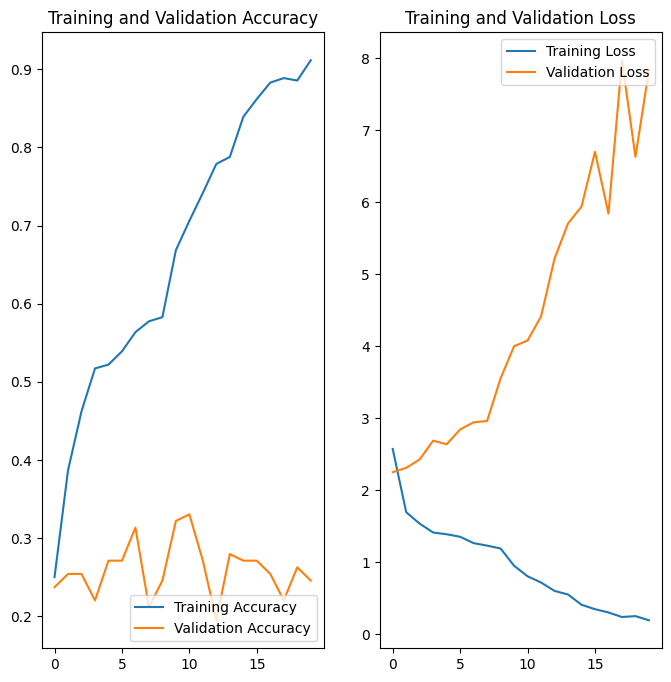

In [79]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### Todo: Write your findings after the model fit, see if there is an evidence of model overfit or underfit

### Write your findings here

In [81]:
# Findings : we can observe that training accuracy is in the range of 90% while validation accuracy is in the between 20 to 30% only.
# thus model is performing well only on training data while it's performance is poor on validation data
# this indicates significant overfit
# lets incoporate augmentation strategy to see if it helps against the overfitting

In [82]:
# Todo, after you have analysed the model fit history for presence of underfit or overfit, choose an appropriate data augumentation strategy. 
# Your code goes here
data_augmentation = tf.keras.Sequential([
  layers.RandomFlip("horizontal_and_vertical"),
  layers.RandomRotation(0.2),
])
# we will use randomflip and random rotation as our augmentation strategy

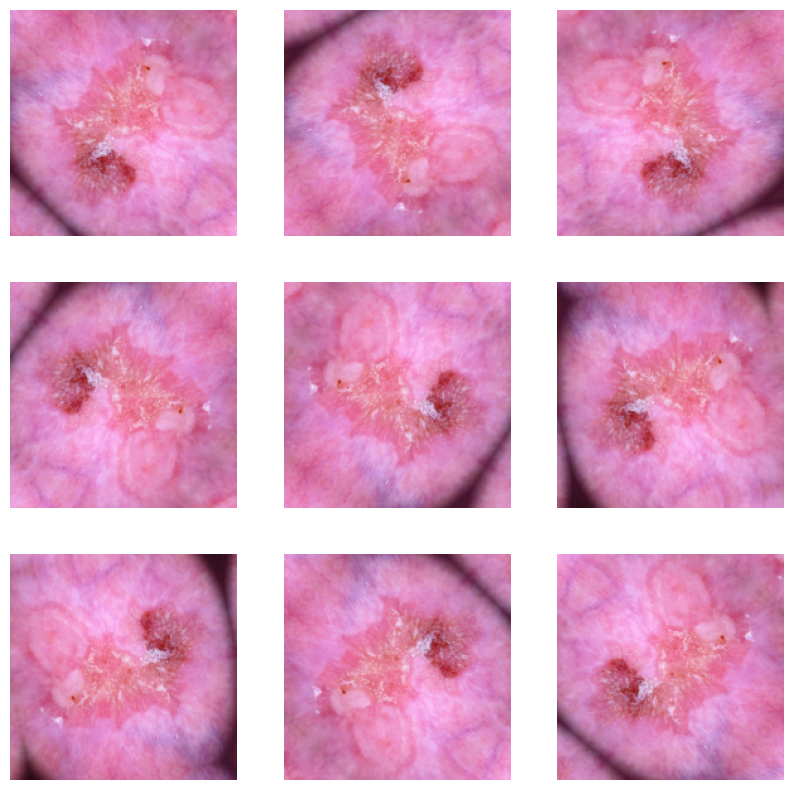

In [83]:
# Todo, visualize how your augmentation strategy works for one instance of training image.
# Your code goes here
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    augmented_images=data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    #plt.title(class_names[labels[0]])
    plt.axis("off")

### Todo:
### Create the model, compile and train the model


In [84]:
## You can use Dropout layer if there is an evidence of overfitting in your findings

## Your code goes here

num_classes = 9

model = Sequential([
  data_augmentation,  # augmentation layer used here

  layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.25), # drop out layer

  layers.Conv2D(128, 3, padding='same', activation='relu'),
  layers.Conv2D(128, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.25),  # dropout layer

  layers.Flatten(),
  layers.Dense(512, activation='relu'),
  layers.Dropout(0.25),  # drop out layer

  layers.Dense(num_classes, activation='softmax')
])

# drop out layer and aumentation layer has been included in order to reduce overfitting

### Compiling the model

In [85]:
## Your code goes here
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

### Training the model

In [87]:
## Your code goes here, note: train your model for 20 epochs
# history = ## your training code
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
70/70 [==============================] - 18s 221ms/step - loss: 2.7314 - accuracy: 0.1956 - val_loss: 2.2198 - val_accuracy: 0.1356
Epoch 2/20
70/70 [==============================] - 15s 218ms/step - loss: 2.0247 - accuracy: 0.2099 - val_loss: 2.2368 - val_accuracy: 0.1356
Epoch 3/20
70/70 [==============================] - 15s 214ms/step - loss: 2.0327 - accuracy: 0.1885 - val_loss: 2.1977 - val_accuracy: 0.1356
Epoch 4/20
70/70 [==============================] - 15s 214ms/step - loss: 2.0264 - accuracy: 0.1983 - val_loss: 2.1806 - val_accuracy: 0.1356
Epoch 5/20
70/70 [==============================] - 15s 217ms/step - loss: 2.0089 - accuracy: 0.2242 - val_loss: 2.1766 - val_accuracy: 0.1441
Epoch 6/20
70/70 [==============================] - 15s 217ms/step - loss: 2.0043 - accuracy: 0.2322 - val_loss: 2.1349 - val_accuracy: 0.1356
Epoch 7/20
70/70 [==============================] - 15s 215ms/step - loss: 1.9066 - accuracy: 0.2894 - val_loss: 2.1282 - val_accuracy: 0.3390

### Visualizing the results

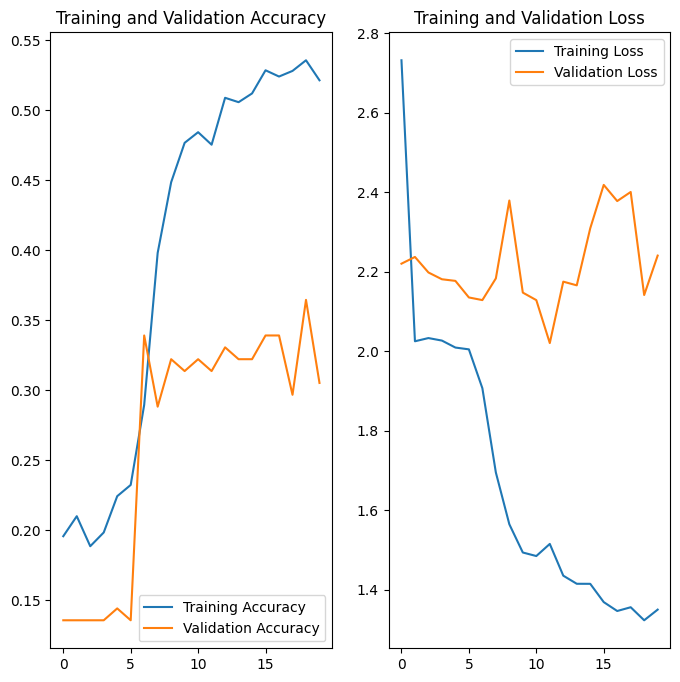

In [88]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### Todo: Write your findings after the model fit, see if there is an evidence of model overfit or underfit. Do you think there is some improvement now as compared to the previous model run?

In [89]:
# Findings : in our previous run, training accuracy was in the range of 90% while validation accuracy was in the range of 20-30%. THus there was significant overfitting
# Now, with incoporation of augmentation strategy and drop-out layer, training accuracy reduces to between 50-55 % while validation accuracy improves to 30-35%
# thus difference between training accuracy and validation accuracy has reduced indicating that overfitting has been reduced
# thus, there has been an improvement compared to previous model run as far as overfitting is concerned
# however, as training accuracy has reduced to 50-55 % there is still scope of improvement in model performance

#### **Todo:** Find the distribution of classes in the training dataset.
#### **Context:** Many times real life datasets can have class imbalance, one class can have proportionately higher number of samples compared to the others. Class imbalance can have a detrimental effect on the final model quality. Hence as a sanity check it becomes important to check what is the distribution of classes in the data.

In [90]:
## Your code goes here.
image_dict = {}
for element in class_names:
    image_dict[element] = len(list(data_dir_train.glob(element+'/*.jpg')))   
print(image_dict) 

{'actinic keratosis': 114, 'basal cell carcinoma': 376, 'dermatofibroma': 95, 'melanoma': 438, 'nevus': 357, 'pigmented benign keratosis': 462, 'seborrheic keratosis': 77, 'squamous cell carcinoma': 181, 'vascular lesion': 139}


In [91]:
# as we can observe above, "melanoma" and "pigmented benign keratosis" classes have more than 400 data points.
# on the other hand, "serborrheic keratosis" has less than 100 data points
# this signifies significant class imbalance
# lets plot above trends to get visual feeling of this class distribution 

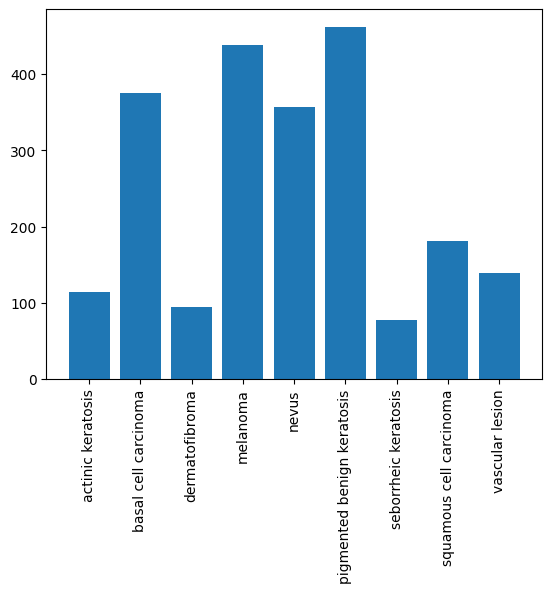

In [92]:
label_names = list(image_dict.keys())
label_count = list(image_dict.values())
import matplotlib.pyplot as plt
plt.bar(range(len(image_dict)), label_count, tick_label=label_names)
plt.xticks(rotation=90)
plt.show()

#### **Todo:** Write your findings here: 
#### - Which class has the least number of samples? -** **Class "serborrheic keratosis" has least number of samples**.**
#### - Which classes dominate the data in terms proportionate number of samples?  **Class "melanoma" and "pigmented benign keratosis" dominate with more than 400 data points followed by "nevus" and "basal cell carcinoma" each having more than 300 samples**



#### **Todo:** Rectify the class imbalance
#### **Context:** You can use a python package known as `Augmentor` (https://augmentor.readthedocs.io/en/master/) to add more samples across all classes so that none of the classes have very few samples.

In [93]:
!pip install Augmentor

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


To use `Augmentor`, the following general procedure is followed:

1. Instantiate a `Pipeline` object pointing to a directory containing your initial image data set.<br>
2. Define a number of operations to perform on this data set using your `Pipeline` object.<br>
3. Execute these operations by calling the `Pipeline’s` `sample()` method.


In [98]:
path_to_training_dataset= "/dataset/Skin cancer ISIC The International Skin Imaging Collaboration/Train/"  # we had already stored path in this variable "To do"
# here we are using string variable instead of Poxipath variable defined earlier
# reason being, inside for loop, class_name which is string is being added to this variable
# hence path can not be Poxipath as operation + between Poxipath and string is not supported
import Augmentor
for i in class_names:
    p = Augmentor.Pipeline(path_to_training_dataset + i)
    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
    p.sample(500) ## We are adding 500 samples per class to make sure that none of the classes are sparse.

Initialised with 114 image(s) found.
Output directory set to /dataset/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F25801F9990>: 100%|██████████| 500/500 [00:20<00:00, 24.25 Samples/s]


Initialised with 376 image(s) found.
Output directory set to /dataset/Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F24FAF0A440>: 100%|██████████| 500/500 [00:18<00:00, 26.73 Samples/s]


Initialised with 95 image(s) found.
Output directory set to /dataset/Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F24FA9B76A0>: 100%|██████████| 500/500 [00:19<00:00, 26.02 Samples/s]


Initialised with 438 image(s) found.
Output directory set to /dataset/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1024x768 at 0x7F250611A8C0>: 100%|██████████| 500/500 [01:41<00:00,  4.91 Samples/s]


Initialised with 357 image(s) found.
Output directory set to /dataset/Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x7F2580497E20>: 100%|██████████| 500/500 [01:34<00:00,  5.32 Samples/s]


Initialised with 462 image(s) found.
Output directory set to /dataset/Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F25A3024850>: 100%|██████████| 500/500 [00:19<00:00, 25.26 Samples/s]


Initialised with 77 image(s) found.
Output directory set to /dataset/Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x7F2580497A30>: 100%|██████████| 500/500 [00:46<00:00, 10.81 Samples/s]


Initialised with 181 image(s) found.
Output directory set to /dataset/Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F2580494FA0>: 100%|██████████| 500/500 [00:18<00:00, 26.61 Samples/s]


Initialised with 139 image(s) found.
Output directory set to /dataset/Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F2593ABBE50>: 100%|██████████| 500/500 [00:21<00:00, 23.44 Samples/s]


Augmentor has stored the augmented images in the output sub-directory of each of the sub-directories of skin cancer types.. Lets take a look at total count of augmented images.

In [99]:
image_count_train = len(list(data_dir_train.glob('*/output/*.jpg')))
print(image_count_train)

4500


In [100]:
# this as expected : 9 classes X 500 images each = total 4500 total augmented images

### Lets see the distribution of augmented data after adding new images to the original training data.

In [104]:
path_list_new = [x for x in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
path_list_new

['/dataset/Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis/output/seborrheic keratosis_original_ISIC_0011099.jpg_723fc1ba-17b9-49d4-b469-91d359f96dac.jpg',
 '/dataset/Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis/output/seborrheic keratosis_original_ISIC_0011132.jpg_caca94fe-ca6b-4e81-b657-0cd9bf85b3c4.jpg',
 '/dataset/Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis/output/seborrheic keratosis_original_ISIC_0010866.jpg_4c61b82c-6eb6-43c1-95d3-d373ad304f05.jpg',
 '/dataset/Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis/output/seborrheic keratosis_original_ISIC_0010979.jpg_2d684a0c-10ad-4cb1-a831-8346ed7ec5a0.jpg',
 '/dataset/Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis/output/seborrheic keratosis_original_ISIC_0011163.jpg_64df3ed6-13b0-4909-9205-54af8da2d138.jpg',
 '/dataset/Skin

In [105]:
lesion_list_new = [os.path.basename(os.path.dirname(os.path.dirname(y))) for y in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
lesion_list_new

['seborrheic keratosis',
 'seborrheic keratosis',
 'seborrheic keratosis',
 'seborrheic keratosis',
 'seborrheic keratosis',
 'seborrheic keratosis',
 'seborrheic keratosis',
 'seborrheic keratosis',
 'seborrheic keratosis',
 'seborrheic keratosis',
 'seborrheic keratosis',
 'seborrheic keratosis',
 'seborrheic keratosis',
 'seborrheic keratosis',
 'seborrheic keratosis',
 'seborrheic keratosis',
 'seborrheic keratosis',
 'seborrheic keratosis',
 'seborrheic keratosis',
 'seborrheic keratosis',
 'seborrheic keratosis',
 'seborrheic keratosis',
 'seborrheic keratosis',
 'seborrheic keratosis',
 'seborrheic keratosis',
 'seborrheic keratosis',
 'seborrheic keratosis',
 'seborrheic keratosis',
 'seborrheic keratosis',
 'seborrheic keratosis',
 'seborrheic keratosis',
 'seborrheic keratosis',
 'seborrheic keratosis',
 'seborrheic keratosis',
 'seborrheic keratosis',
 'seborrheic keratosis',
 'seborrheic keratosis',
 'seborrheic keratosis',
 'seborrheic keratosis',
 'seborrheic keratosis',


In [106]:
dataframe_dict_new = dict(zip(path_list_new, lesion_list_new))

In [107]:
df2 = pd.DataFrame(list(dataframe_dict_new.items()),columns = ['Path','Label'])
new_df = original_df.append(df2)

In [108]:
new_df['Label'].value_counts()

pigmented benign keratosis    962
melanoma                      938
basal cell carcinoma          876
nevus                         857
squamous cell carcinoma       681
vascular lesion               639
actinic keratosis             614
dermatofibroma                595
seborrheic keratosis          577
Name: Label, dtype: int64

In [109]:
# classes look much more balanced now
# earlier, class with minimum data had only 77 data points while maixmum one had 462 datapoints
# thus, maximum data had more than 6 times data points of that contained in class with minimum data points
# with augmentation, maximum data points in class are 962 while minimum are 577
# thus maximum datapoints to minimumdata points ratio is less than 2
# even other classes look more balanced
# lets also make a plot to feel this visually

<Axes: >

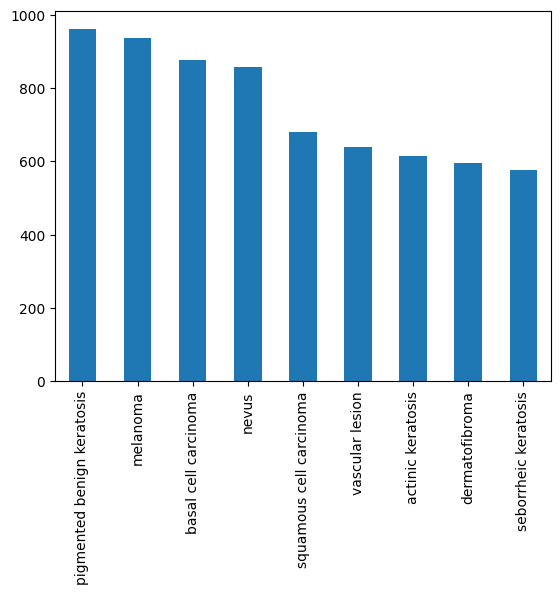

In [111]:

new_df.Label.value_counts().plot(kind='bar')

So, now we have added 500 images to all the classes to maintain some class balance. We can add more images as we want to improve training process.

#### **Todo**: Train the model on the data created using Augmentor

In [112]:
batch_size = 32
img_height = 180
img_width = 180

#### **Todo:** Create a training dataset

In [113]:
data_dir_train= pathlib.Path("/dataset/Skin cancer ISIC The International Skin Imaging Collaboration/Train")  # "path to directory with training data + data created using augmentor"
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2, # 20% of data from training folder will be retained for validation purpose
  subset = "training", ## Todo choose the correct parameter value, so that only training data is refered to,,
  image_size=(img_height, img_width),
  label_mode = "categorical", # we are explictly specifying this parameter as we have categorical dataset. THis will also labels are encoded into categorical vectors for categorical entropy loss
  batch_size=batch_size)


Found 6739 files belonging to 9 classes.
Using 5392 files for training.


In [114]:
# original number of files in training folder : 2239
# augmented images added : 4500
# total : 4500 + 2239 = 6739 images
# above number matches this figure

#### **Todo:** Create a validation dataset

In [115]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = "validation",  ## Todo choose the correct parameter value, so that only validation data is refered to,
  image_size=(img_height, img_width),
  label_mode = "categorical", # we are explictly specifying this parameter as we have categorical dataset. THis will also labels are encoded into categorical vectors for categorical entropy loss
  batch_size=batch_size)
# here, we are not using data from test directory
# only data from train directory being used (which underwent augmentation operation)
# out of total train data, 20% is being used for validation purpose and 80 % for training purpose

Found 6739 files belonging to 9 classes.
Using 1347 files for validation.


#### **Todo:** Create your model (make sure to include normalization)

In [116]:
## your code goes here
from tensorflow.keras.layers import BatchNormalization
num_classes = 9

model = Sequential([
  layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width, 3)),

  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.BatchNormalization(), # normalization
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.BatchNormalization(),  # normalization
  layers.MaxPooling2D(),
  layers.Dropout(0.25),

  layers.Conv2D(128, 3, padding='same', activation='relu'),
  layers.BatchNormalization(),     # normalization
  layers.Conv2D(128, 3, padding='same', activation='relu'),
  layers.BatchNormalization(),     # normalization
  layers.MaxPooling2D(),
  layers.Dropout(0.25),


  layers.Flatten(),
  layers.Dense(512, activation='relu'),
  layers.Dropout(0.25),

  layers.Dense(num_classes, activation='softmax')
])
# normalization has been included

#### **Todo:** Compile your model (Choose optimizer and loss function appropriately)

In [117]:
## your code goes here
## Your code goes here
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

#### **Todo:**  Train your model

In [118]:
#epochs = 30
epochs = 50
## Your code goes here, use 50 epochs.
history = history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)# your model fit code

Epoch 1/50
169/169 [==============================] - 66s 363ms/step - loss: 30.2838 - accuracy: 0.2144 - val_loss: 108.6194 - val_accuracy: 0.0898
Epoch 2/50
169/169 [==============================] - 58s 340ms/step - loss: 2.0695 - accuracy: 0.2049 - val_loss: 48.7433 - val_accuracy: 0.1166
Epoch 3/50
169/169 [==============================] - 63s 368ms/step - loss: 2.1090 - accuracy: 0.1816 - val_loss: 4.0213 - val_accuracy: 0.1826
Epoch 4/50
169/169 [==============================] - 58s 337ms/step - loss: 2.0110 - accuracy: 0.2328 - val_loss: 2.0308 - val_accuracy: 0.2079
Epoch 5/50
169/169 [==============================] - 58s 338ms/step - loss: 2.0065 - accuracy: 0.2333 - val_loss: 2.0372 - val_accuracy: 0.2108
Epoch 6/50
169/169 [==============================] - 58s 337ms/step - loss: 1.9580 - accuracy: 0.2389 - val_loss: 1.8620 - val_accuracy: 0.2635
Epoch 7/50
169/169 [==============================] - 58s 339ms/step - loss: 1.9192 - accuracy: 0.2669 - val_loss: 1.7738 - va

#### **Todo:**  Visualize the model results

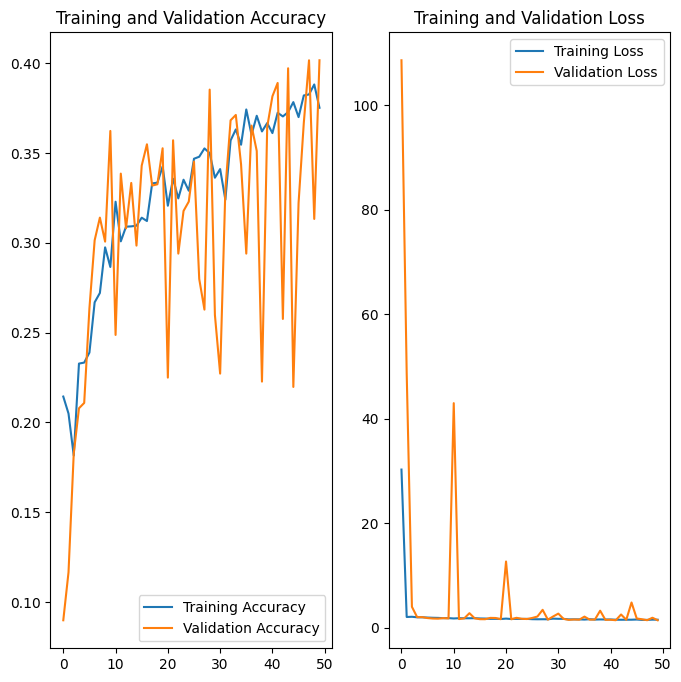

In [119]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### **Todo:**  Analyze your results here. Did you get rid of underfitting/overfitting? Did class rebalance help?



In [120]:
# observations : after augmentation, trainng accuracy is in the range of 35-40% while validation accuracy closely flactuates around training accuracy as can be visible from the plot
# thus, rebalacing does seem to be helping with overfitting
# however, it has reduced the  training accuracy of the model thus has introduced an underfitting
# the solution to this should be trying out different architechures and selecting the optimum architechure  